# Flatiron Health mPC: MICE

**OBJECTIVE: Impute missing variables in the training dataset using multiple imputation chained equations (MICE). Five non-missing training sets will be construced using MICE along with 5 test sets. A gradient boosted model will be fit to each training dataset and a test set AUC will be calculated. The 1 year AUCs from the test set will be pooled to get a final estimate.** 

**BACKGROUND: The variables with the most missingness at time of metastatic diagnosis are ECOG (50%), labs (30%), and changes in weight (11%). These three variables have high predictive value in our models. Up until this point, missingness has been handled by making "unknown" a level in the ECOG variable and imputing median for lab values and weight loss. While this imputation strategy is simple and fast, it likely understimates the variance of variables and disturb relations between variables when the data is not missing completely at random.** 

**Variables that will be imputed with MICE:** 
1. **ECOG (48% missing)**
2. **BMI (15% missing)**
3. **Weight (25% missing)**
4. **Percent change in weight and weight slope (11% missing)**
5. **Socioeconomic status (20% missing)**
6. **Stage (40%)**
7. **Labs at time of advanced diagnosis (30% missing)**
8. **Subset of summary labs (40% missing)**

**Five complete training sets will be imputed using the Python package "miceforest" which uses lightgbm as a backend. Five complete test sets will also be imputed from the final model used to impute the training set values. All existing variables including outcome variables like death status and time until event will be utilized to aid in the imputations. In addition, auxillary variables such as receipt of treatment, weight and BMI at 3 months, and labs at 3 months will be created to augment imputations.**   

**After complete training and test sets are constructed, a gradient boosting survival model will be built for each training set in the same fashion as in the crude imputation notebook. Final test AUCs will be pooled using Rubin's rules.**

**OUTLINE:**
1. **Building auxillary variables** 
2. **Performing MICE on training and test sets** 
3. **Building gradient boosting models on imputed datasets**
4. **Pooling results**

## 1. Building auxillary varibles 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### 1.1 Preprocessing

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(15141, 15141)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(3786, 3786)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(18927, 18927)

### 1.2 Treatment 

**Add indicator variables for receipt of various treatment. The 5 major treatment categories include: ADT, FDA approved therapy for metastatic HSPC that isn't ADT, alpha beta emitters, sipuleucel-T, and an FDA approved therapy for metastatic CRPC.** 

In [6]:
line_therapy = pd.read_csv('LineOfTherapy.csv')
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')
abe = pd.read_csv('Enhanced_MetPC_AlphaBetaEmitters.csv')
sipt = pd.read_csv('Enhanced_MetPC_Provenge.csv')
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [7]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]

adt = adt[adt['PatientID'].isin(df['PatientID'])]
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

abe = abe[abe['PatientID'].isin(df['PatientID'])]
abe.loc[:, 'AdministrationDate'] = pd.to_datetime(abe['AdministrationDate'])

sipt = sipt[sipt['PatientID'].isin(df['PatientID'])]
sipt.loc[:, 'StartDate'] = pd.to_datetime(sipt['StartDate'])

enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df['PatientID'])]
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [8]:
adt = pd.merge(adt, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID')

adt = (
    adt
    .assign(adt_diff = (adt['StartDate'] - adt['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -90')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

adt.loc[:,'late_adt'] = 1

In [9]:
abe = pd.merge(abe, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID')

abe = (
    abe
    .assign(abe_diff = (abe['AdministrationDate'] - abe['MetDiagnosisDate']).dt.days)
    .query('abe_diff >= -90')
    .sort_values(by = ['PatientID', 'AdministrationDate'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

abe.loc[:, 'abe'] = 1

In [10]:
sipt = pd.merge(sipt, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID')

sipt = (
    sipt
    .assign(sipt_diff = (sipt['StartDate'] - sipt['MetDiagnosisDate']).dt.days)
    .query('sipt_diff >= -90')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

sipt.loc[:, 'sipt'] = 1

In [11]:
# List of FDA approved drugs for mPC as of July 2023. Clinical study drug is also included. 
fda_yes = [
    'Abiraterone',
    'Apalutamide',
    'Cabazitaxel',
    'Carboplatin',
    'Cisplatin',
    'Darolutamide',
    'Docetaxel',
    'Enzalutamide',
    'Mitoxantrone',
    'Olaparib',
    'Oxaliplatin',
    'Paclitaxel',
    'Pembrolizumab',
    'Rucaparib',
    'Clinical Study Drug'
]

In [12]:
hspc = line_therapy.query('LineSetting == "mHSPC"')

crpc_1 = (
    line_therapy
    .query('LineSetting == "mCRPC"')
    .query('LineNumber == 1')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

crpc_2 = (
    line_therapy
    .query('LineSetting == "mCRPC"')
    .query('LineNumber == 2')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

crpc_3 = (
    line_therapy
    .query('LineSetting == "mCRPC"')
    .query('LineNumber == 3')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))


In [13]:
hspc.loc[:, 'hspc'] = np.where(
    hspc['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

hspc = (
    hspc
    .sort_values(by = ['PatientID', 'hspc'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

hspc.loc[:, 'hspc'] = 1

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [14]:
crpc_1.loc[:, 'crpc_1'] = np.where(
    crpc_1['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

crpc_1 = crpc_1[['PatientID', 'crpc_1']]

In [15]:
crpc_2.loc[:, 'crpc_2'] = np.where(
    crpc_2['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

crpc_2 = crpc_2[['PatientID', 'crpc_2']]

In [16]:
crpc_3.loc[:, 'crpc_3'] = np.where(
    crpc_3['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

crpc_3 = crpc_3[['PatientID', 'crpc_3']]

In [17]:
df = pd.merge(df, adt, on = 'PatientID', how = 'outer')

df = pd.merge(df, abe, on = 'PatientID', how = 'outer')

df = pd.merge(df, sipt, on = 'PatientID', how = 'outer')

df = pd.merge(df, hspc, on = 'PatientID', how = 'outer')

df = pd.merge(df, crpc_1, on = 'PatientID', how = 'outer')

df = pd.merge(df, crpc_2, on = 'PatientID', how = 'outer')

df = pd.merge(df, crpc_3, on = 'PatientID', how = 'outer')

In [18]:
df[['late_adt', 'abe', 'sipt', 'hspc', 'crpc_1', 'crpc_2', 'crpc_3']] = df[['late_adt', 'abe', 'sipt', 'hspc', 'crpc_1', 'crpc_2', 'crpc_3']].fillna(value = 0)

In [19]:
df.late_adt.value_counts()

1.0    11837
0.0     7090
Name: late_adt, dtype: int64

In [20]:
df.abe.value_counts()

0.0    17284
1.0     1643
Name: abe, dtype: int64

In [21]:
df.sipt.value_counts()

0.0    17591
1.0     1336
Name: sipt, dtype: int64

In [22]:
df.hspc.value_counts()

0.0    13819
1.0     5108
Name: hspc, dtype: int64

In [23]:
df.crpc_1.value_counts()

0.0    9891
1.0    9036
Name: crpc_1, dtype: int64

In [24]:
df.crpc_2.value_counts()

0.0    13308
1.0     5619
Name: crpc_2, dtype: int64

In [25]:
df.crpc_3.value_counts()

0.0    15747
1.0     3180
Name: crpc_3, dtype: int64

In [26]:
row_ID(df)

(18927, 18927)

In [27]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
abe            DataFrame              PatientID  abe\<...>\n[1643 rows x 2 columns]
adt            DataFrame               PatientID  lat<...>n[11837 rows x 2 columns]
crpc_1         DataFrame               PatientID  crp<...>\n[9788 rows x 2 columns]
crpc_2         DataFrame               PatientID  crp<...>\n[5983 rows x 2 columns]
crpc_3         DataFrame               PatientID  crp<...>\n[3509 rows x 2 columns]
df             DataFrame               PatientID Gend<...>18927 rows x 235 columns]
enhanced_met   DataFrame               PatientID Diag<...>[18927 rows x 13 columns]
hspc           DataFrame               PatientID  hsp<...>\n[5108 rows x 2 columns]
line_therapy   DataFrame               PatientID     <...>n[31397 rows x 9 columns]
sipt           DataFrame              PatientID  sipt<...>\n[1336 rows x 2 columns]
test           DataFrame              PatientID Gende<...>[3786 rows x 228 columns]


In [28]:
# Keep df 
del abe
del adt
del crpc_1
del crpc_2
del crpc_3
del enhanced_met
del hspc
del line_therapy
del sipt

### 1.3 Weight

In [29]:
vitals = pd.read_csv('Vitals.csv')

vitals = vitals[vitals['PatientID'].isin(df['PatientID'])]

In [30]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df['PatientID'])]
                                                              
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

#### Weight and BMI

In [31]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [32]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [33]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [34]:
# Weight elgibliity window is -60 to +60 from 6 months after metastatic diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = ((weight['TestDate'] - (weight['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('weight_date_diff >= -60 and weight_date_diff <= 60')
)

In [35]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [36]:
# Select weight closest to +180 from metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_180'})
)

In [37]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [38]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [39]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_180 = lambda x: (x['weight_180']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [40]:
df = pd.merge(df, weight_bmi_wide, on = 'PatientID', how = 'outer')

In [41]:
row_ID(df)

(18927, 18927)

#### Percent change in weight 

In [42]:
# Select elgbility window of -90 to +365 days from metastatic diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 365')
)

In [43]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [44]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [45]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [46]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [47]:
weight_tcomb.loc[:, 'weight_pct_1yr'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [48]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_1yr'])
    .filter(items = ['PatientID', 'weight_pct_1yr'])
)

In [49]:
df = pd.merge(df, weight_pct_wide, on = 'PatientID', how = 'outer')

In [50]:
row_ID(df)

(18927, 18927)

#### Slope of weight 

In [51]:
import datetime as dt
from scipy.stats import linregress 

In [52]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [53]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope_1yr'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope_1yr'])) 

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [54]:
df = pd.merge(df, weight_slope_wide, on = 'PatientID', how = 'outer')

In [55]:
row_ID(df)

(18927, 18927)

In [56]:
%whos DataFrame

Variable             Type         Data/Info
-------------------------------------------
df                   DataFrame               PatientID Gend<...>18927 rows x 239 columns]
enhanced_met         DataFrame               PatientID Diag<...>[18927 rows x 13 columns]
height_avg           DataFrame               PatientID  hei<...>n[18699 rows x 2 columns]
test                 DataFrame              PatientID Gende<...>[3786 rows x 228 columns]
train                DataFrame               PatientID Gend<...>15141 rows x 228 columns]
vitals               DataFrame                 PatientID   <...>647303 rows x 15 columns]
weight               DataFrame                PatientID   T<...>[493261 rows x 4 columns]
weight_bmi_wide      DataFrame               PatientID  wei<...>n[12166 rows x 3 columns]
weight_pct_wide      DataFrame                PatientID  we<...>n[14825 rows x 2 columns]
weight_slope_wide    DataFrame               PatientID  wei<...>n[14825 rows x 2 columns]
weight_tcomb

In [57]:
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 1.4 Static labs 

In [58]:
lab = pd.read_csv('Lab.csv')

In [59]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [60]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [61]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [62]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6") | 
    (lab['LOINC'] == "2857-1")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [63]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6'), 
    (lab_core['LOINC'] == '2857-1')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp', 
           'psa']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [64]:
lab_core = (
    lab_core
    .dropna(subset = ['TestResultCleaned'])
)

In [65]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [66]:
# Elgibliity window is +30 to +330 from metastatic diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = ((lab_core['ResultDate'] - (lab_core['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('lab_date_diff >= -150 and lab_date_diff <= 150')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [67]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [68]:
# Select lab closest to 180 days after metastatic diagnosis and then pivot to a wide table. 
lab_180_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_180',
        'creatinine': 'creatinine_180',
        'hemoglobin': 'hemoglobin_180',
        'neutrophil_count': 'neutrophil_count_180',
        'total_bilirubin': 'total_bilirubin_180',
        'wbc': 'wbc_180',
        'sodium': 'sodium_180', 
        'bicarb': 'bicarb_180',
        'calcium': 'calcium_180',
        'ast': 'ast_180', 
        'alt': 'alt_180',
        'platelet': 'platelet_180',
        'potassium': 'potassium_180',
        'chloride': 'chloride_180',
        'bun': 'bun_180', 
        'alp': 'alp_180',
        'psa': 'psa_180'})
)

lab_180_wide.columns.name = None

In [69]:
df = pd.merge(df, lab_180_wide, on = 'PatientID', how = 'outer')

In [70]:
row_ID(df)

(18927, 18927)

### 1.5 Summary labs

In [71]:
# Elgibility window is negative infinity to +365 from metastatic diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 365')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [72]:
# Pivot table of maximum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['alp', 'alt', 'ast', 'calcium', 'creatinine', 'psa', 'total_bilirubin', 'wbc'])
    .reset_index()
    .rename(columns = {
        'alp': 'alp_max_f',
        'alt': 'alt_max_f',
        'ast': 'ast_max_f',
        'calcium': 'calcium_max_f',
        'creatinine': 'creatinine_max_f',
        'psa': 'psa_max_f',
        'total_bilirubin': 'total_bilirubin_max_f',
        'wbc': 'wbc_max_f'})
)

lab_max_wide.columns.name = None

In [73]:
# Pivot table of minimum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['albumin', 'bicarb', 'hemoglobin', 'platelet', 'sodium', 'wbc'])
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min_f',
        'bicarb': 'bicarb_min_f',
        'hemoglobin': 'hemoglobin_min_f',
        'platelet': 'platelet_min_f',
        'sodium': 'sodium_min_f', 
        'wbc': 'wbc_min_f'})
)

lab_min_wide.columns.name = None

In [74]:
df = pd.merge(df, lab_max_wide, on = 'PatientID', how = 'outer')

In [75]:
row_ID(df)

(18927, 18927)

In [76]:
df = pd.merge(df, lab_min_wide, on = 'PatientID', how = 'outer')

In [77]:
row_ID(df)

(18927, 18927)

In [78]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
df                  DataFrame               PatientID Gend<...>18927 rows x 270 columns]
enhanced_met        DataFrame               PatientID Diag<...>[18927 rows x 13 columns]
lab                 DataFrame                  PatientID  <...>503499 rows x 17 columns]
lab_180_wide        DataFrame               PatientID  alb<...>[14007 rows x 18 columns]
lab_core            DataFrame                  PatientID R<...>368274 rows x 11 columns]
lab_core_win        DataFrame                  PatientID R<...>1418619 rows x 7 columns]
lab_core_win_summ   DataFrame                  PatientID R<...>2374164 rows x 7 columns]
lab_max_wide        DataFrame               PatientID  alp<...>n[15226 rows x 9 columns]
lab_min_wide        DataFrame               PatientID  alb<...>n[15226 rows x 7 columns]
test                DataFrame              PatientID Gende<...>[3786 rows x 228 columns]
train               Data

In [79]:
del enhanced_met
del lab
del lab_180_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_max_wide
del lab_min_wide

### 1.6 Replacing 'unknown' with np.nan for variables of interest

In [80]:
df = df.replace({'stage': {'unknown': np.nan, '0': 'I'},
                 'ecog_diagnosis': {'unknown': np.nan}})

In [81]:
df.stage.value_counts(dropna = False)

IV     9423
NaN    7474
II     1065
III     819
I       146
Name: stage, dtype: int64

In [82]:
df.ecog_diagnosis.value_counts(dropna = False)

NaN    12841
0.0     2680
1.0     2343
2.0      779
3.0      270
4.0       14
Name: ecog_diagnosis, dtype: int64

### 1.7 Dropping unwanted summary variables 

In [83]:
# Pasted from crude_model_building file 
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'psa_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'psa_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'psa_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [84]:
df = df.drop(columns = drop_labs)

In [85]:
df.shape

(18927, 184)

In [86]:
df.loc[:, 'alp_max_na'] = np.where(df['alp_max'].isna(), 1, 0)
df.loc[:, 'alt_max_na'] = np.where(df['alt_max'].isna(), 1, 0)
df.loc[:, 'ast_max_na'] = np.where(df['ast_max'].isna(), 1, 0)
df.loc[:, 'calcium_max_na'] = np.where(df['calcium_max'].isna(), 1, 0)
df.loc[:, 'creatinine_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'psa_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'total_bilirubin_max_na'] = np.where(df['total_bilirubin_max'].isna(), 1, 0)
df.loc[:, 'wbc_max_na'] = np.where(df['wbc_max'].isna(), 1, 0)
df.loc[:, 'albumin_min_na'] = np.where(df['albumin_min'].isna(), 1, 0)
df.loc[:, 'bicarb_min_na'] = np.where(df['bicarb_min'].isna(), 1, 0)
df.loc[:, 'hemoglobin_min_na'] = np.where(df['hemoglobin_min'].isna(), 1, 0)
df.loc[:, 'platelet_min_na'] = np.where(df['platelet_min'].isna(), 1, 0)
df.loc[:, 'sodium_min_na'] = np.where(df['sodium_min'].isna(), 1, 0)
df.loc[:, 'wbc_min_na'] = np.where(df['wbc_min'].isna(), 1, 0)

In [87]:
df.shape

(18927, 198)

In [88]:
row_ID(df)

(18927, 18927)

In [89]:
df_mice = df

In [90]:
df_mice.to_csv('df_mice.csv', index = False, header = True)

### 1.8 Final processing

In [91]:
train_mice = df_mice[df_mice['PatientID'].isin(train['PatientID'])]
train_mice = train_mice.set_index('PatientID')

In [92]:
test_mice = df_mice[df_mice['PatientID'].isin(test['PatientID'])]
test_mice = test_mice.set_index('PatientID')

In [93]:
train_mice.shape

(15141, 197)

In [94]:
test_mice.shape

(3786, 197)

In [95]:
list(train_mice.select_dtypes(include = ['object']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [96]:
to_be_categorical = list(train_mice.select_dtypes(include = ['object']).columns)

In [97]:
to_be_categorical.append('met_year')

In [98]:
# miceforest requires columns to be category or int/float, so object columns will be converted to category. 
for x in list(to_be_categorical):
    train_mice[x] = train_mice[x].astype('category')

In [99]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [100]:
list(train_mice.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [101]:
# List of variable that have missing values which MICE will impute. 
list(train_mice.columns[train_mice.isnull().any()])

['PSADiagnosis',
 'PSAMetDiagnosis',
 'stage',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'weight_pct_change',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'alp_max',
 'alt_max',
 'ast_max',
 'calcium_max',
 'creatinine_max',
 'psa_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'bicarb_min',
 'hemoglobin_min',
 'platelet_min',
 'sodium_min',
 'wbc_min',
 'psa_slope',
 'weight_180',
 'bmi_180',
 'weight_pct_1yr',
 'weight_slope_1yr',
 'albumin_180',
 'alp_180',
 'alt_180',
 'ast_180',
 'bicarb_180',
 'bun_180',
 'calcium_180',
 'chloride_180',
 'creatinine_180',
 'hemoglobin_180',
 'neutrophil_count_180',
 'platelet_180',
 'potassium_180',
 'psa_180',
 'sodium_180',
 'total_bilirubin_180',
 'wbc_180',
 'alp_max_f',
 'alt_ma

In [102]:
len(train_mice.columns[train_mice.isnull().any()])

74

## 2. Building training and test set using miceforest 

In [103]:
import miceforest as mf

### 2.1 Finding ideal parameters

In [104]:
# Create kernel. 
kernel = mf.ImputationKernel(
    train_mice,
    datasets = 5,
    save_all_iterations = True,
    random_state = 42)

In [105]:
# Using the first ImputationKernel in kernel to tune parameters with the default settings.
optimal_parameters, losses = kernel.tune_parameters(
    dataset = 0,
    optimization_steps = 5,
    verbose = 1,
    random_state = 42)

PSAMetDiagnosis | 0 - 1 - 2 - 3 - 4 - 
weight_pct_1yr | 0 - 1 - 2 - 3 - 4 - 
weight_slope_1yr | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_min_f | 0 - 1 - 2 - 3 - 4 - 
creatinine_max_f | 0 - 1 - 2 - 3 - 4 - 
calcium_max_f | 0 - 1 - 2 - 3 - 4 - 
alp_max_f | 0 - 1 - 2 - 3 - 4 - 
ast_max_f | 0 - 1 - 2 - 3 - 4 - 
alt_max_f | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_max_f | 0 - 1 - 2 - 3 - 4 - 
wbc_min_f | 0 - 1 - 2 - 3 - 4 - 
wbc_max_f | 0 - 1 - 2 - 3 - 4 - 
albumin_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_min_f | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_180 | 0 - 1 - 2 - 3 - 4 - 
PSADiagnosis | 0 - 1 - 2 - 3 - 4 - 
bun_180 | 0 - 1 - 2 - 3 - 4 - 
creatinine_180 | 0 - 1 - 2 - 3 - 4 - 
calcium_180 | 0 - 1 - 2 - 3 - 4 - 
alp_180 | 0 - 1 - 2 - 3 - 4 - 
ast_180 | 0 - 1 - 2 - 3 - 4 - 
alt_180 | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_180 | 0 - 1 - 2 - 3 - 4 - 
albumin_180 | 0 - 1 - 2 - 3 - 4 - 
wbc_180 | 0 - 1 - 2 - 3 - 4 - 
bicarb_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_180 | 0 - 1 - 2 - 3 - 4 - 
weight_180 | 0 - 1 - 2 - 3 - 

### 2.2 Building training datasets

In [106]:
# Run mice with our newly tuned parameters.
kernel.mice(iterations = 5, 
            variable_parameters = optimal_parameters,
            verbose = 0)

In [107]:
for x in range(5): 
    kernel.complete_data(dataset = x).to_csv('mice_tr'+str(x)+'.csv', index = True, header = True)

### 2.3 Building test datasets

In [108]:
test_imputed = kernel.impute_new_data(new_data = test_mice, verbose = 0)

In [109]:
for x in range(5): 
    test_imputed.complete_data(dataset = x).to_csv('mice_te'+str(x)+'.csv', index = True, header = True)

## 3. Building gradient boosting models 

In [110]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load

import matplotlib.pyplot as plt

import warnings

### 3.1 Model 0

#### Preprocessing and building pipeline 

In [111]:
# Import first training set
train_mice0 = pd.read_csv('mice_tr0.csv', index_col = 'PatientID')

# Import all test sets
test_mice0 = pd.read_csv('mice_te0.csv', index_col = 'PatientID')
test_mice1 = pd.read_csv('mice_te1.csv', index_col = 'PatientID')
test_mice2 = pd.read_csv('mice_te2.csv', index_col = 'PatientID')
test_mice3 = pd.read_csv('mice_te3.csv', index_col = 'PatientID')
test_mice4 = pd.read_csv('mice_te4.csv', index_col = 'PatientID')

In [112]:
# Combine all test sets into 1 to get more robust estimates from models
test_mice = pd.concat([test_mice0, test_mice1, test_mice2, test_mice3, test_mice4], ignore_index = False)

In [113]:
print(train_mice0.shape)
print(test_mice.shape)

(15141, 197)
(18930, 197)


In [114]:
# Auxillary variables generated for MICE
(
    train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]
    .union(train_mice0.columns[train_mice0.columns.str.match('late_adt|abe|sipt|hspc')])
)

Index(['abe', 'albumin_180', 'albumin_min_f', 'alp_180', 'alp_max_f',
       'alt_180', 'alt_max_f', 'ast_180', 'ast_max_f', 'bicarb_180',
       'bicarb_min_f', 'bmi_180', 'bun_180', 'calcium_180', 'calcium_max_f',
       'chloride_180', 'creatinine_180', 'creatinine_max_f', 'crpc_1',
       'crpc_2', 'crpc_3', 'hemoglobin_180', 'hemoglobin_min_f', 'hspc',
       'late_adt', 'neutrophil_count_180', 'platelet_180', 'platelet_min_f',
       'potassium_180', 'psa_180', 'psa_max_f', 'sipt', 'sodium_180',
       'sodium_min_f', 'total_bilirubin_180', 'total_bilirubin_max_f',
       'wbc_180', 'wbc_max_f', 'wbc_min_f', 'weight_180', 'weight_pct_1yr',
       'weight_slope_1yr'],
      dtype='object')

In [115]:
#Remove auxillary variables for train and test sets
mice_drop = (
    train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]
    .union(train_mice0.columns[train_mice0.columns.str.match('late_adt|abe|sipt|hspc')])
)

train_mice0 = train_mice0.drop(columns = mice_drop)

test_mice = test_mice.drop(columns = mice_drop)

In [116]:
print(train_mice0.shape)
print(test_mice.shape)

(15141, 155)
(18930, 155)


In [117]:
# Generate ecog_na, stage_na, and ses_na indicator variables
train_mice0['ecog_na'] = np.where(train_mice0.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice0['stage_na'] = np.where(train_mice0.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

test_mice['ecog_na'] = np.where(test_mice.index.isin(test.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
test_mice['stage_na'] = np.where(test_mice.index.isin(test.query('stage == "unknown"').PatientID), 1, 0)

In [118]:
# List of cateogrical varaibles 
to_be_categorical

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment',
 'met_year']

In [119]:
# Convert object variables to categorical variables for train and test 
for x in list(to_be_categorical):
    train_mice0[x] = train_mice0[x].astype('category')
    
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [120]:
list(train_mice0.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [121]:
# Death status to boolean 
train_mice0['death_status'] = train_mice0['death_status'].astype('bool')

test_mice['death_status'] = test_mice['death_status'].astype('bool')

In [122]:
#Define validation and subtrain
val_IDs = pd.read_csv('val_IDs.csv')

val_mice0 = train_mice0[train_mice0.index.isin(val_IDs['PatientID'])]

sub_train_mice0 = train_mice0[~train_mice0.index.isin(val_IDs['PatientID'])]

In [123]:
print(train_mice0.shape)
print(sub_train_mice0.shape)
print(val_mice0.shape)

(15141, 157)
(11355, 157)
(3786, 157)


In [124]:
# 'X' datasets
train_mice0_x = train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice0_x = sub_train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

val_mice0_x = val_mice0.drop(columns = ['death_status', 'timerisk_activity'])

test_mice_x = test_mice.drop(columns = ['death_status', 'timerisk_activity'])

In [125]:
print(train_mice0_x.shape)
print(sub_train_mice0_x.shape)
print(val_mice0_x.shape)
print(test_mice_x.shape)

(15141, 155)
(11355, 155)
(3786, 155)
(18930, 155)


In [126]:
# 'Y' datasets 
y_dtypes = train_mice0[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values],
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train_mice0[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val_mice0[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test_mice[['death_status', 'timerisk_activity']].values],
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

In [127]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'PSADiagnosis',
    'PSAMetDiagnosis',
    'delta_met_diagnosis',
    'crpc_time',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'psa_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'psa_slope',
    'icd_count']

# List of categorical features.
categorical_features = list(train_mice0_x.select_dtypes(include = ['category']).columns)

# Transformer will apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('std_scaler', StandardScaler())])

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [128]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

#### Hyperparameter tuning

In [129]:
sub_train_mice0_xt = preprocessor_red.fit_transform(sub_train_mice0_x)
val_mice0_xt = preprocessor_red.transform(val_mice0_x)

gbm_mice0_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice0_exp.fit(sub_train_mice0_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       35806.5749           7.1378           38.52m
         2       36193.6824           7.5691           38.52m
         3       36362.9641           6.8122           38.54m
         4       35967.2473           6.5205           38.54m
         5       36378.5839           6.2204           38.57m
         6       36007.5083           6.0505           38.60m
         7       35778.8153           5.9021           38.60m
         8       35879.1462           5.3759           38.56m
         9       35515.2244           5.7450           38.52m
        10       35862.4532           5.7978           38.52m
        20       35496.7984           3.9667           38.32m
        30       35664.2757           3.1643           37.95m
        40       35058.3116           2.3708           37.70m
        50       35336.8770           1.9552           37.52m
        60       35024.8069           1.6527           37.26m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [130]:
gbm0_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice0_exp.staged_predict(val_mice0_xt)]

In [131]:
gbm0_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice0_exp.staged_predict(sub_train_mice0_xt)]

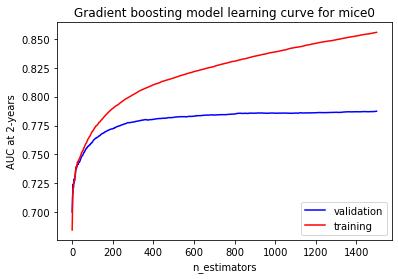

In [132]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm0_staged_auc))
plt.plot(x, gbm0_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm0_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice0')

plt.show()

In [133]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm0_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm0_staged_auc[x:x+24]))

In [134]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm0_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm0_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 925
Validation dataset AUC before degrading: 0.7858821801034896
Training dataset AUC before degrading: 0.8360639366103648


In [135]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 925,
                                                                        learning_rate = 0.05,
                                                                        random_state = 10))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 10)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 10,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_mice0_x, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1892
max_resources_: 15141
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 1892
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 3784
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 7568
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 15136
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('std_scaler',
                                                                                                                                            StandardScaler())]),
                                                                                                                           ['age',
                                                                                                 

In [136]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 3,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.75}

In [137]:
gbm_search_results = pd.DataFrame(gbm_search.cv_results_)

In [138]:
gbm_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__gradientboostingsurvivalanalysis__max_depth,param_estimator__gradientboostingsurvivalanalysis__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
15,2,7568,295.538415,0.530320,0.041879,0.000452,3,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.801679,0.755287,0.775214,0.777393,0.019002,1,0.867236,0.876564,0.876628,0.873476,0.004413
18,3,15136,1175.648900,3.049941,0.077599,0.001383,3,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.797608,0.765990,0.767291,0.776963,0.014608,2,0.831204,0.844989,0.843177,0.839790,0.006116
16,2,7568,269.284677,25.115155,0.037234,0.004666,2,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.800398,0.755251,0.771667,0.775772,0.018658,3,0.822118,0.834222,0.833040,0.829793,0.005449
14,2,7568,318.963936,0.493396,0.040954,0.000646,3,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.801031,0.753898,0.771027,0.775319,0.019480,4,0.865647,0.874677,0.874698,0.871674,0.004262
17,3,15136,1161.710414,5.716183,0.062095,0.000934,2,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.793923,0.764900,0.764649,0.774490,0.013741,5,0.798527,0.812608,0.812218,0.807784,0.006548
10,1,3784,60.819211,0.214376,0.023934,0.000919,2,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.784073,0.752724,0.765829,0.767542,0.012856,6,0.859152,0.859784,0.860957,0.859964,0.000748
9,1,3784,65.517945,0.107219,0.028887,0.002269,3,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.780437,0.749470,0.767235,0.765714,0.012688,7,0.912167,0.915700,0.916527,0.914798,0.001891
11,1,3784,71.910306,3.048911,0.025811,0.003381,3,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.781180,0.747789,0.766666,0.765211,0.013671,8,0.908558,0.912875,0.914550,0.911994,0.002524
12,1,3784,65.614519,0.341714,0.029128,0.000179,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.776862,0.754428,0.763551,0.764947,0.009211,9,0.955917,0.959639,0.959765,0.958440,0.001785
13,1,3784,70.752549,0.674868,0.031839,0.004954,4,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.779429,0.749342,0.765995,0.764922,0.012307,10,0.953748,0.958837,0.958968,0.957184,0.002431


**The above best tree depth and subsample will be used for all models moving forward mainly due to the computational cost of searching for these parameters for each MICE training set. It also seems likely that these two hyperparamters have small impact on test set AUC performance and are unlikely to change by much for each training set.** 

#### Building model and assessing performance 

In [139]:
gbm_mice0 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 925,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice0.fit(train_mice0_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       49609.2215           9.8966           43.67m
         2       49572.3210          10.4110           43.87m
         3       49390.7824           9.4719           44.11m
         4       49569.4130           8.8257           44.11m
         5       49469.2405           8.6880           44.36m
         6       49248.1400           8.1168           44.34m
         7       49460.1090           8.0450           44.23m
         8       49586.7039           7.6641           44.13m
         9       49228.3787           7.1399           44.04m
        10       49502.1676           7.2202           43.97m
        20       49124.0993           5.8684           43.32m
        30       48938.9987           4.5402           42.68m
        40       48708.9502           3.8394           42.23m
        50       48704.2910           2.8030           41.74m
        60       48748.5424           1.7833           41.27m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [140]:
dump(gbm_mice0, 'gbm_mice0.joblib') 

['gbm_mice0.joblib']

In [141]:
gbm_risk_scores_te = gbm_mice0.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7739972890524494


In [142]:
gbm_risk_scores_tr = gbm_mice0.predict(train_mice0_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8256840481751762


In [143]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [144]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004093344772927353


In [145]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [146]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004131329467504827


In [147]:
mice_auc_data = {'mice_dataset': ['mice_0'],
                 'auc_2yr_te': [gbm_auc_te],
                 'sem_te': [standard_error_te],
                 'auc_2yr_tr': [gbm_auc_tr],
                 'sem_tr': [standard_error_tr]}

mice_auc_df = pd.DataFrame(mice_auc_data)

In [148]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.773997,0.004093,0.825684,0.004131


In [149]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [150]:
times = np.arange(30, 1810, 30)
mice0_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice0_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice_auc_over5 = pd.DataFrame(times_data, index = ['mice_0'])

In [151]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.928904,0.864093,0.840115,0.836288,0.845611,0.837766,0.820487,0.828629,0.822264,0.819491,...,0.762153,0.760338,0.7602,0.762227,0.762661,0.761704,0.765279,0.764763,0.769232,0.766055


In [152]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [153]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice0_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 182


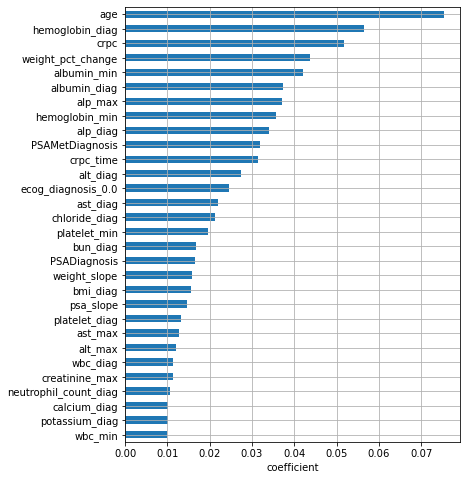

In [154]:
# Dataframe of coefficients for each variable 
coefficients_mice0 = pd.DataFrame(
    gbm_mice0.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice0.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice0.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [155]:
coefficients_mice = (
    coefficients_mice0
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [156]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.2 Model 1

#### Preprocessing and building pipeline 

In [157]:
# Import second training set
train_mice1 = pd.read_csv('mice_tr1.csv', index_col = 'PatientID')

In [158]:
print(train_mice1.shape)

(15141, 197)


In [159]:
train_mice1.isna().sum().sum()

0

In [160]:
train_mice1 = train_mice1.drop(columns = mice_drop)

In [161]:
print(train_mice1.shape)
print(test_mice.shape)

(15141, 155)
(18930, 157)


In [162]:
train_mice1['ecog_na'] = np.where(train_mice1.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice1['stage_na'] = np.where(train_mice1.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [163]:
for x in list(to_be_categorical):
    train_mice1[x] = train_mice1[x].astype('category')
    
list(train_mice1.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [164]:
train_mice1['death_status'] = train_mice1['death_status'].astype('bool')

In [165]:
val_mice1 = train_mice1[train_mice1.index.isin(val_IDs['PatientID'])]

sub_train_mice1 = train_mice1[~train_mice1.index.isin(val_IDs['PatientID'])]

In [166]:
print(train_mice1.shape)
print(sub_train_mice1.shape)
print(val_mice1.shape)

(15141, 157)
(11355, 157)
(3786, 157)


In [167]:
train_mice1_x = train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice1_x = sub_train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

val_mice1_x = val_mice1.drop(columns = ['death_status', 'timerisk_activity'])

In [168]:
print(train_mice1_x.shape)
print(sub_train_mice1_x.shape)
print(val_mice1_x.shape)

(15141, 155)
(11355, 155)
(3786, 155)


#### Hyperparameter tuning 

In [169]:
sub_train_mice1_xt = preprocessor_red.fit_transform(sub_train_mice1_x)
val_mice1_xt = preprocessor_red.transform(val_mice1_x)

gbm_mice1_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice1_exp.fit(sub_train_mice1_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       35807.9397           6.9212           38.97m
         2       36195.9609           6.3881           38.87m
         3       36366.1707           7.2107           38.91m
         4       35971.7734           7.1958           38.92m
         5       36379.7202           6.2206           38.93m
         6       36008.2076           6.4466           38.88m
         7       35780.4063           5.8071           38.83m
         8       35877.8891           5.2817           38.81m
         9       35514.0871           5.5901           38.78m
        10       35858.4904           5.3237           38.74m
        20       35496.6238           4.4785           38.41m
        30       35659.1397           3.0740           38.11m
        40       35050.7777           2.2697           37.83m
        50       35326.3589           1.9113           37.56m
        60       35017.4067           1.4455           37.28m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [170]:
gbm1_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice1_exp.staged_predict(val_mice1_xt)]

In [171]:
gbm1_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice1_exp.staged_predict(sub_train_mice1_xt)]

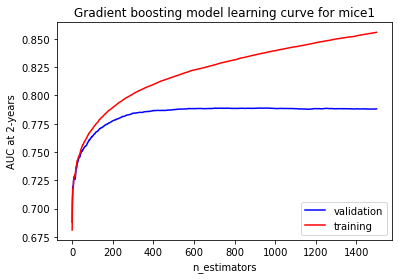

In [172]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm1_staged_auc))
plt.plot(x, gbm1_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm1_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice1')

plt.show()

In [173]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm1_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm1_staged_auc[x:x+24]))

In [174]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm1_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm1_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 625
Validation dataset AUC before degrading: 0.7884909359506813
Training dataset AUC before degrading: 0.8235597023805907


#### Building model and assessing performance 

In [175]:
gbm_mice1 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice1.fit(train_mice1_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       49607.7517          10.5525           29.48m
         2       49571.2103          10.1710           29.49m
         3       49390.3643           9.1429           29.41m
         4       49569.8367           8.9079           29.35m
         5       49470.7517           8.0165           29.32m
         6       49249.6929           8.2292           29.28m
         7       49461.3348           8.1457           29.22m
         8       49589.4930           7.5259           29.17m
         9       49228.6089           7.4367           29.12m
        10       49499.5100           6.7911           29.08m
        20       49127.6405           5.6969           28.58m
        30       48940.2932           4.1662           28.11m
        40       48714.8787           3.1570           27.63m
        50       48714.1084           2.6304           27.16m
        60       48759.2193           1.4635           26.69m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [176]:
dump(gbm_mice1, 'gbm_mice1.joblib') 

['gbm_mice1.joblib']

In [177]:
gbm_risk_scores_te = gbm_mice1.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7730702902848371


In [178]:
gbm_risk_scores_tr = gbm_mice1.predict(train_mice1_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8169570648163549


In [179]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [180]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004100546202106724


In [181]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [182]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004143334322696161


In [183]:
mice_auc_data = {'mice_dataset': 'mice_1',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [184]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.773997,0.004093,0.825684,0.004131
1,mice_1,0.773070,0.004101,0.816957,0.004143


In [185]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [186]:
times = np.arange(30, 1810, 30)
mice1_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice1_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice1_auc_over5_df = pd.DataFrame(times_data, index = ['mice_1'])

mice_auc_over5 = mice_auc_over5.append(mice1_auc_over5_df, ignore_index = False)

In [187]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.928904,0.864093,0.840115,0.836288,0.845611,0.837766,0.820487,0.828629,0.822264,0.819491,...,0.762153,0.760338,0.76020,0.762227,0.762661,0.761704,0.765279,0.764763,0.769232,0.766055
mice_1,0.938534,0.855832,0.839844,0.839509,0.848354,0.838090,0.820419,0.827062,0.819228,0.817008,...,0.764224,0.762176,0.76193,0.763859,0.764817,0.764278,0.768409,0.768135,0.773135,0.769328


In [188]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [189]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice1_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 164


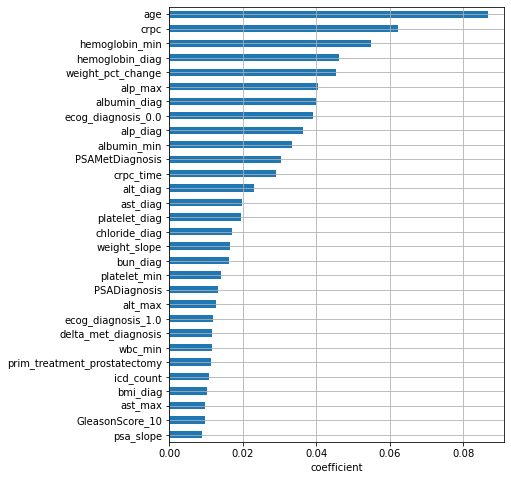

In [190]:
# Dataframe of coefficients for each variable 
coefficients_mice1 = pd.DataFrame(
    gbm_mice1.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice1.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice1.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [191]:
coefficients_mice1_df = (
    coefficients_mice1
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [192]:
coefficients_mice = coefficients_mice.append(coefficients_mice1_df, ignore_index = True)

In [193]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.3 Model 3

#### Preprocessing 

In [194]:
train_mice2 = pd.read_csv('mice_tr2.csv', index_col = 'PatientID')

In [195]:
print(train_mice2.shape)

(15141, 197)


In [196]:
train_mice2.isna().sum().sum()

0

In [197]:
train_mice2 = train_mice2.drop(columns = mice_drop)

In [198]:
print(train_mice2.shape)

(15141, 155)


In [199]:
train_mice2['ecog_na'] = np.where(train_mice2.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice2['stage_na'] = np.where(train_mice2.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [200]:
for x in list(to_be_categorical):
    train_mice2[x] = train_mice2[x].astype('category')
    
list(train_mice2.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [201]:
train_mice2['death_status'] = train_mice2['death_status'].astype('bool')

In [202]:
val_mice2 = train_mice2[train_mice2.index.isin(val_IDs['PatientID'])]

sub_train_mice2 = train_mice2[~train_mice2.index.isin(val_IDs['PatientID'])]

In [203]:
print(train_mice2.shape)
print(sub_train_mice2.shape)
print(val_mice2.shape)

(15141, 157)
(11355, 157)
(3786, 157)


In [204]:
train_mice2_x = train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice2_x = sub_train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

val_mice2_x = val_mice2.drop(columns = ['death_status', 'timerisk_activity'])

In [205]:
print(train_mice2_x.shape)
print(sub_train_mice2_x.shape)
print(val_mice2_x.shape)

(15141, 155)
(11355, 155)
(3786, 155)


#### Hyperparameter tuning 

In [206]:
sub_train_mice2_xt = preprocessor_red.fit_transform(sub_train_mice2_x)
val_mice2_xt = preprocessor_red.transform(val_mice2_x)

gbm_mice2_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice2_exp.fit(sub_train_mice2_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       35807.1892           6.5397           39.02m
         2       36196.1749           6.9628           38.95m
         3       36365.3109           6.3873           38.89m
         4       35971.2955           6.6917           38.83m
         5       36380.6484           5.7545           38.78m
         6       36010.8122           6.0981           38.76m
         7       35783.4363           6.0009           38.73m
         8       35880.0614           5.1789           38.73m
         9       35516.5078           5.5692           38.69m
        10       35864.2051           5.0462           38.66m
        20       35500.7884           4.4692           38.40m
        30       35667.4523           3.0105           38.11m
        40       35058.4543           2.1033           37.84m
        50       35337.8900           2.1292           37.57m
        60       35026.2974           1.7805           37.30m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [207]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice2_exp.staged_predict(val_mice2_xt)]

In [208]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice2_exp.staged_predict(sub_train_mice2_xt)]

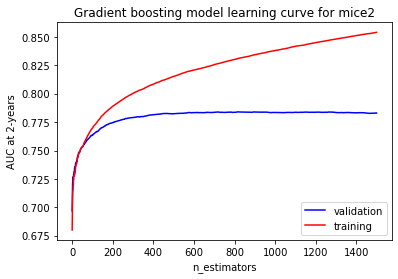

In [209]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice2')

plt.show()

In [210]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [211]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 450
Validation dataset AUC before degrading: 0.7824976280559206
Training dataset AUC before degrading: 0.8119203745448658


#### Building model and assessing performance 

In [212]:
gbm_mice2 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice2.fit(train_mice2_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       49608.9761           9.6559           21.19m
         2       49572.0238          10.2683           21.21m
         3       49392.1032           9.0968           21.16m
         4       49572.0158           9.1439           21.16m
         5       49472.2028           8.2805           21.10m
         6       49251.7963           8.4171           21.04m
         7       49461.7600           7.5703           20.99m
         8       49590.0819           7.6338           20.93m
         9       49231.8660           7.4477           20.88m
        10       49505.4247           8.1367           20.84m
        20       49129.0505           5.8567           20.34m
        30       48938.7704           4.3481           19.86m
        40       48720.3736           3.8225           19.38m
        50       48708.4084           2.4603           18.91m
        60       48755.6825           1.9562           18.43m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [213]:
dump(gbm_mice2, 'gbm_mice2.joblib') 

['gbm_mice2.joblib']

In [214]:
gbm_risk_scores_te = gbm_mice2.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 year:', gbm_auc_te)

Test set AUC at 2 year: 0.7718784195725261


In [215]:
gbm_risk_scores_tr = gbm_mice2.predict(train_mice2_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 year:', gbm_auc_tr)

Training set AUC at 2 year: 0.807680792579551


In [216]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [217]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004110018677300323


In [218]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [219]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004320363108615317


In [220]:
mice_auc_data = {'mice_dataset': 'mice_2',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [221]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.773997,0.004093,0.825684,0.004131
1,mice_1,0.773070,0.004101,0.816957,0.004143
2,mice_2,0.771878,0.004110,0.807681,0.004320


In [222]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [223]:
times = np.arange(30, 1810, 30)
mice2_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice2_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice2_auc_over5_df = pd.DataFrame(times_data, index = ['mice_2'])

mice_auc_over5 = mice_auc_over5.append(mice2_auc_over5_df, ignore_index = False)

In [224]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.928904,0.864093,0.840115,0.836288,0.845611,0.837766,0.820487,0.828629,0.822264,0.819491,...,0.762153,0.760338,0.760200,0.762227,0.762661,0.761704,0.765279,0.764763,0.769232,0.766055
mice_1,0.938534,0.855832,0.839844,0.839509,0.848354,0.838090,0.820419,0.827062,0.819228,0.817008,...,0.764224,0.762176,0.761930,0.763859,0.764817,0.764278,0.768409,0.768135,0.773135,0.769328
mice_2,0.937258,0.857651,0.836417,0.834835,0.844006,0.833931,0.816445,0.823575,0.816348,0.813052,...,0.764569,0.762767,0.762684,0.764612,0.765368,0.764845,0.769258,0.768813,0.773587,0.770271


In [225]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [226]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice2_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 140


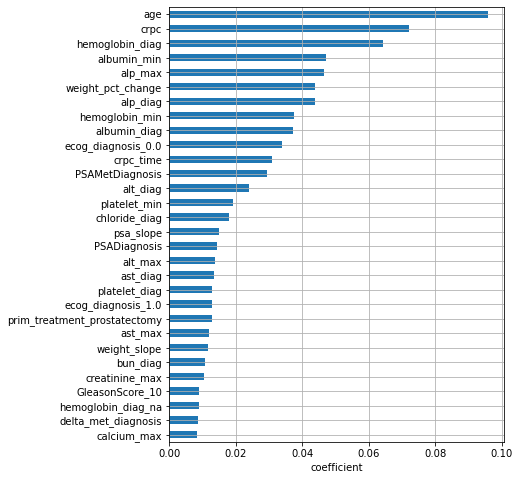

In [227]:
# Dataframe of coefficients for each variable 
coefficients_mice2 = pd.DataFrame(
    gbm_mice2.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice2.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice2.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [228]:
coefficients_mice2_df = (
    coefficients_mice2
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [229]:
coefficients_mice = coefficients_mice.append(coefficients_mice2_df, ignore_index = True)

In [230]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.4 Model 4

#### Preprocessing 

In [231]:
train_mice3 = pd.read_csv('mice_tr3.csv', index_col = 'PatientID')

In [232]:
print(train_mice3.shape)

(15141, 197)


In [233]:
train_mice3.isna().sum().sum()

0

In [234]:
train_mice3 = train_mice3.drop(columns = mice_drop)

In [235]:
print(train_mice3.shape)

(15141, 155)


In [236]:
train_mice3['ecog_na'] = np.where(train_mice3.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice3['stage_na'] = np.where(train_mice3.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [237]:
for x in list(to_be_categorical):
    train_mice3[x] = train_mice3[x].astype('category')
    
list(train_mice3.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [238]:
train_mice3['death_status'] = train_mice3['death_status'].astype('bool')

In [239]:
val_mice3 = train_mice3[train_mice3.index.isin(val_IDs['PatientID'])]

sub_train_mice3 = train_mice3[~train_mice3.index.isin(val_IDs['PatientID'])]

In [240]:
print(train_mice3.shape)
print(sub_train_mice3.shape)
print(val_mice3.shape)

(15141, 157)
(11355, 157)
(3786, 157)


In [241]:
train_mice3_x = train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice3_x = sub_train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

val_mice3_x = val_mice3.drop(columns = ['death_status', 'timerisk_activity'])

In [242]:
print(train_mice3_x.shape)
print(sub_train_mice3_x.shape)
print(val_mice3_x.shape)

(15141, 155)
(11355, 155)
(3786, 155)


#### Hyperparameter tuning 

In [243]:
sub_train_mice3_xt = preprocessor_red.fit_transform(sub_train_mice3_x)
val_mice3_xt = preprocessor_red.transform(val_mice3_x)

gbm_mice3_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice3_exp.fit(sub_train_mice3_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       35807.0295           7.4216           38.47m
         2       36193.8695           7.1365           38.46m
         3       36362.9237           6.5669           38.44m
         4       35968.2620           6.4232           38.40m
         5       36378.1173           6.3142           38.38m
         6       36006.1045           6.0101           38.36m
         7       35778.5859           5.8178           38.33m
         8       35878.6665           5.1644           38.29m
         9       35514.0979           5.8758           38.27m
        10       35857.2407           4.9797           38.24m
        20       35495.5546           4.3471           37.94m
        30       35659.1483           2.9634           37.69m
        40       35061.4771           2.7254           37.43m
        50       35342.5585           2.0300           37.18m
        60       35016.5533           1.6283           36.91m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [244]:
gbm3_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice3_exp.staged_predict(val_mice3_xt)]

In [245]:
gbm3_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice3_exp.staged_predict(sub_train_mice3_xt)]

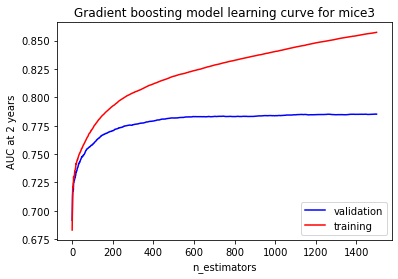

In [246]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm3_staged_auc))
plt.plot(x, gbm3_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm3_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice3')

plt.show()

In [247]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm3_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm3_staged_auc[x:x+24]))

In [248]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm3_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm3_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 600
Validation dataset AUC before degrading: 0.7830638337657422
Training dataset AUC before degrading: 0.8235854275010255


#### Model building and performance assessment 

In [249]:
gbm_mice3 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice3.fit(train_mice3_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       49609.7623           9.4072           28.50m
         2       49571.0225          10.3088           28.47m
         3       49390.7897           9.6287           28.34m
         4       49569.9012           9.4961           28.25m
         5       49470.9853           8.3761           28.18m
         6       49250.0432           7.7206           28.11m
         7       49461.0988           8.2147           28.06m
         8       49586.4366           7.6633           28.00m
         9       49226.5393           7.1411           27.95m
        10       49500.3201           7.3710           27.89m
        20       49127.6704           5.7187           27.40m
        30       48936.2357           4.3677           26.92m
        40       48714.6742           3.1051           26.44m
        50       48700.4698           2.8859           25.97m
        60       48756.2004           1.9028           25.50m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [250]:
dump(gbm_mice3, 'gbm_mice3.joblib') 

['gbm_mice3.joblib']

In [251]:
gbm_risk_scores_te = gbm_mice3.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7722590754828409


In [252]:
gbm_risk_scores_tr = gbm_mice3.predict(train_mice3_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8166207306567599


In [253]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [254]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004097280021427178


In [255]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [256]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.00420134398047182


In [257]:
mice_auc_data = {'mice_dataset': 'mice_3',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [258]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.773997,0.004093,0.825684,0.004131
1,mice_1,0.773070,0.004101,0.816957,0.004143
2,mice_2,0.771878,0.004110,0.807681,0.004320
3,mice_3,0.772259,0.004097,0.816621,0.004201


In [259]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [260]:
times = np.arange(30, 1810, 30)
mice3_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice3_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice3_auc_over5_df = pd.DataFrame(times_data, index = ['mice_3'])

mice_auc_over5 = mice_auc_over5.append(mice3_auc_over5_df, ignore_index = False)

In [261]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.928904,0.864093,0.840115,0.836288,0.845611,0.837766,0.820487,0.828629,0.822264,0.819491,...,0.762153,0.760338,0.760200,0.762227,0.762661,0.761704,0.765279,0.764763,0.769232,0.766055
mice_1,0.938534,0.855832,0.839844,0.839509,0.848354,0.838090,0.820419,0.827062,0.819228,0.817008,...,0.764224,0.762176,0.761930,0.763859,0.764817,0.764278,0.768409,0.768135,0.773135,0.769328
mice_2,0.937258,0.857651,0.836417,0.834835,0.844006,0.833931,0.816445,0.823575,0.816348,0.813052,...,0.764569,0.762767,0.762684,0.764612,0.765368,0.764845,0.769258,0.768813,0.773587,0.770271
mice_3,0.920580,0.855594,0.836459,0.834208,0.844403,0.836067,0.820205,0.826476,0.819472,0.815705,...,0.764346,0.762434,0.761962,0.764132,0.764698,0.763869,0.768060,0.768031,0.772544,0.769228


In [262]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [263]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice3_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 163


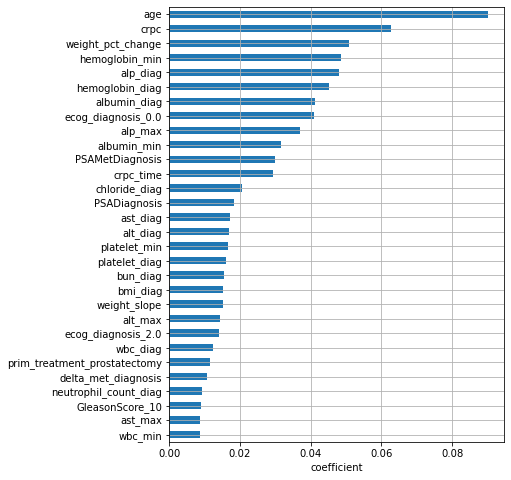

In [264]:
# Dataframe of coefficients for each variable 
coefficients_mice3 = pd.DataFrame(
    gbm_mice3.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice3.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice3.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [265]:
coefficients_mice3_df = (
    coefficients_mice3
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [266]:
coefficients_mice = coefficients_mice.append(coefficients_mice3_df, ignore_index = True)

In [267]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.5 Model 5

#### Preprocessing

In [268]:
train_mice4 = pd.read_csv('mice_tr4.csv', index_col = 'PatientID')

In [269]:
train_mice4.shape

(15141, 197)

In [270]:
train_mice4.isna().sum().sum()

0

In [271]:
train_mice4 = train_mice4.drop(columns = mice_drop)

In [272]:
print(train_mice4.shape)

(15141, 155)


In [273]:
train_mice4['ecog_na'] = np.where(train_mice4.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice4['stage_na'] = np.where(train_mice4.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [274]:
for x in list(to_be_categorical):
    train_mice4[x] = train_mice4[x].astype('category')
    
list(train_mice4.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [275]:
train_mice4['death_status'] = train_mice4['death_status'].astype('bool')

In [276]:
val_mice4 = train_mice4[train_mice4.index.isin(val_IDs['PatientID'])]

sub_train_mice4 = train_mice4[~train_mice4.index.isin(val_IDs['PatientID'])]

In [277]:
print(train_mice4.shape)
print(sub_train_mice4.shape)
print(val_mice4.shape)

(15141, 157)
(11355, 157)
(3786, 157)


In [278]:
train_mice4_x = train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice4_x = sub_train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

val_mice4_x = val_mice4.drop(columns = ['death_status', 'timerisk_activity'])

In [279]:
print(train_mice4_x.shape)
print(sub_train_mice4_x.shape)
print(val_mice4_x.shape)

(15141, 155)
(11355, 155)
(3786, 155)


#### Hyperparameter tuning

In [280]:
sub_train_mice4_xt = preprocessor_red.fit_transform(sub_train_mice4_x)
val_mice4_xt = preprocessor_red.transform(val_mice4_x)

gbm_mice4_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice4_exp.fit(sub_train_mice4_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       35807.7097           6.5245           39.04m
         2       36196.4851           7.0497           38.92m
         3       36366.4255           7.1326           38.79m
         4       35971.2535           6.9753           38.75m
         5       36381.4664           5.9424           38.72m
         6       36010.0489           6.0439           38.67m
         7       35781.1577           5.9057           38.65m
         8       35879.8236           5.8503           38.62m
         9       35515.1429           5.8315           38.58m
        10       35860.1549           5.1818           38.56m
        20       35499.9370           4.4047           38.28m
        30       35661.1246           3.2849           38.00m
        40       35052.1898           2.2575           37.74m
        50       35332.4019           2.0624           37.46m
        60       35024.3729           1.4295           37.19m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [281]:
gbm4_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice4_exp.staged_predict(val_mice4_xt)]

In [282]:
gbm4_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice4_exp.staged_predict(sub_train_mice4_xt)]

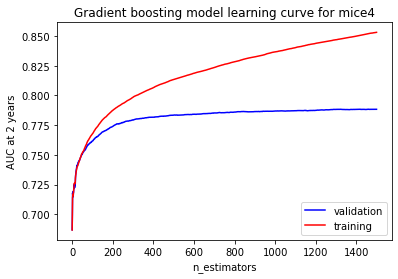

In [283]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm4_staged_auc))
plt.plot(x, gbm4_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm4_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice4')

plt.show()

In [284]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm4_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm4_staged_auc[x:x+24]))

In [285]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm4_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm4_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 825
Validation dataset AUC before degrading: 0.786275596991785
Training dataset AUC before degrading: 0.8294951771096107


#### Model building and performance assessment 

In [286]:
print(train_mice4_x.shape)
print(train_y.shape)

(15141, 155)
(15141,)


In [287]:
gbm_mice4 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice4.fit(train_mice4_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       49608.7783          10.2998           38.91m
         2       49571.3423          10.3547           38.97m
         3       49389.7772           9.5671           38.92m
         4       49570.5795           8.9290           38.88m
         5       49469.7670           8.8065           38.81m
         6       49247.4824           8.6734           38.74m
         7       49457.6894           8.1102           38.71m
         8       49584.2477           7.2273           38.65m
         9       49224.5109           7.5403           38.61m
        10       49500.7029           7.4778           38.56m
        20       49118.8191           5.3733           38.08m
        30       48931.8250           4.0294           37.62m
        40       48711.5944           3.4775           37.13m
        50       48699.8847           2.5901           36.65m
        60       48752.5353           1.8768           36.17m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [288]:
dump(gbm_mice4, 'gbm_mice4.joblib') 

['gbm_mice4.joblib']

In [289]:
gbm_risk_scores_te = gbm_mice4.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7727751322996321


In [290]:
gbm_risk_scores_tr = gbm_mice4.predict(train_mice4_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8216853425702256


In [291]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [292]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004053691786358704


In [293]:
# Bootstrap 10000 2 yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [294]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0041256639988028


In [295]:
mice_auc_data = {'mice_dataset': 'mice_4',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [296]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.773997,0.004093,0.825684,0.004131
1,mice_1,0.773070,0.004101,0.816957,0.004143
2,mice_2,0.771878,0.004110,0.807681,0.004320
3,mice_3,0.772259,0.004097,0.816621,0.004201
4,mice_4,0.772775,0.004054,0.821685,0.004126


In [297]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [298]:
times = np.arange(30, 1810, 30)
mice4_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice4_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice4_auc_over5_df = pd.DataFrame(times_data, index = ['mice_4'])

mice_auc_over5 = mice_auc_over5.append(mice4_auc_over5_df, ignore_index = False)

In [299]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.928904,0.864093,0.840115,0.836288,0.845611,0.837766,0.820487,0.828629,0.822264,0.819491,...,0.762153,0.760338,0.760200,0.762227,0.762661,0.761704,0.765279,0.764763,0.769232,0.766055
mice_1,0.938534,0.855832,0.839844,0.839509,0.848354,0.838090,0.820419,0.827062,0.819228,0.817008,...,0.764224,0.762176,0.761930,0.763859,0.764817,0.764278,0.768409,0.768135,0.773135,0.769328
mice_2,0.937258,0.857651,0.836417,0.834835,0.844006,0.833931,0.816445,0.823575,0.816348,0.813052,...,0.764569,0.762767,0.762684,0.764612,0.765368,0.764845,0.769258,0.768813,0.773587,0.770271
mice_3,0.920580,0.855594,0.836459,0.834208,0.844403,0.836067,0.820205,0.826476,0.819472,0.815705,...,0.764346,0.762434,0.761962,0.764132,0.764698,0.763869,0.768060,0.768031,0.772544,0.769228
mice_4,0.941148,0.864575,0.842846,0.838960,0.847921,0.840051,0.821698,0.827963,0.821445,0.818379,...,0.766003,0.763590,0.763053,0.765207,0.765897,0.764887,0.768636,0.768333,0.773088,0.770166


In [300]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [301]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice4_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 182


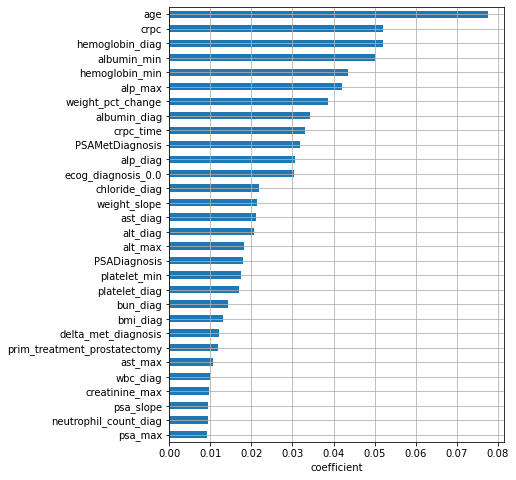

In [302]:
# Dataframe of coefficients for each variable 
coefficients_mice4 = pd.DataFrame(
    gbm_mice4.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice4.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice4.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [303]:
coefficients_mice4_df = (
    coefficients_mice4
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [304]:
coefficients_mice = coefficients_mice.append(coefficients_mice4_df, ignore_index = True)

In [305]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### Part 4. Pooling results

#### 4.1 Pooling AUC

In [306]:
from math import sqrt, exp 
from scipy.stats import t

**Test and training AUCs will be pooled using Rubin’s rules. This is complicated by the fact that AUCs are bounded and thus not normally distributed. The AUCs will therefore be logit transformed to an unbounded scale, then Rubin's rules will be applied to these values, and finally they will be back-transformed into a final pool estimate.** 

In [307]:
# This function is translated from the R package: "psfmi: Prediction Model Selection and Performance Evaluation in
# Multiple Imputed Datasets"

def pool_auc(auc_arr, se_arr, iterations_n):
    
    # pooled SE using Rubin's rules 
    def rr_se(est, se, iterations_n):
        m = iterations_n
        w_auc = np.mean(np.square(se)) # within variance 
        b_auc = np.var(est) # between variance 
        tv_auc = w_auc + (1 + (1/m)) * b_auc # total vairance 
        se_total = sqrt(tv_auc)
        r = (1 + (1/ m)) * (b_auc / w_auc)
        v = (m - 1) * (1 + (1/r))**2
        w = t.ppf(0.975, v) # Percent point function or inverse CDF with df = v
        res = np.array([se_total, w])
        return(res)
    
    # log transform
    auc_log = np.log(auc_arr / (1-auc_arr))
    se_log = se_arr / (auc_arr * (1-auc_arr))
    
    # input log transfomred auc and se to calculat RR's total se
    se_total = rr_se(auc_log, se_log, iterations_n = iterations_n)
    
    # backtransform 
    inv_auc = exp(np.mean(auc_log)) / (1 + exp(np.mean(auc_log)))
    inv_auc_upper = exp(np.mean(auc_log) + (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) + (se_total[1]*se_total[0])))
    inv_auc_lower = exp(np.mean(auc_log) - (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) - (se_total[1]*se_total[0])))
    sem = (inv_auc_upper - inv_auc_lower) / 3.92
    auc_res = np.round(np.array([inv_auc_lower, inv_auc, inv_auc_upper, sem]), 6)
    return(auc_res)

In [308]:
mice_auc_df = pd.read_csv('mice_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                      'sem_te': np.float64,
                                                      'auc_2yr_tr': np.float64,
                                                      'sem_tr': np.float64})

In [309]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.773997,0.004093,0.825684,0.004131
1,mice_1,0.773070,0.004101,0.816957,0.004143
2,mice_2,0.771878,0.004110,0.807681,0.004320
3,mice_3,0.772259,0.004097,0.816621,0.004201
4,mice_4,0.772775,0.004054,0.821685,0.004126


In [310]:
pool_auc_test = pool_auc(mice_auc_df['auc_2yr_te'].values, 
                         mice_auc_df['sem_te'].values, 
                         5)

print(pool_auc_test)

[0.764521 0.772797 0.780866 0.00417 ]


In [311]:
pool_auc_train = pool_auc(mice_auc_df['auc_2yr_tr'].values,
                          mice_auc_df['sem_tr'].values,
                          5)

print(pool_auc_train)

[0.799101 0.817802 0.835122 0.009189]


In [312]:
crude_auc_df = pd.read_csv('crude_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                        'sem_te': np.float64,
                                                        'auc_2yr_tr': np.float64,
                                                        'sem_tr': np.float64})

In [313]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.759629,0.009420,0.806806,0.004366
1,rsf_crude,0.752487,0.009532,0.841038,0.003831
2,ridge_crude,0.740313,0.009651,0.745116,0.004924
3,lasso_crude,0.729804,0.009747,0.734107,0.005027
4,enet_crude,0.730636,0.009755,0.734755,0.005019
5,linear_svm_crude,0.741471,0.009656,0.748665,0.004838


In [314]:
mice_auc_data = {'model': 'gbm_mice',
                 'auc_2yr_te': pool_auc_test[1],
                 'sem_te': pool_auc_test[3],
                 'auc_2yr_tr': pool_auc_train[1],
                 'sem_tr': pool_auc_train[3]}

In [315]:
ml_auc_df = crude_auc_df.append(mice_auc_data, ignore_index = True)

In [316]:
ml_auc_df.sort_values(by = 'auc_2yr_te', ascending = False)

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
6,gbm_mice,0.772797,0.004170,0.817802,0.009189
0,gbm_crude,0.759629,0.009420,0.806806,0.004366
1,rsf_crude,0.752487,0.009532,0.841038,0.003831
5,linear_svm_crude,0.741471,0.009656,0.748665,0.004838
2,ridge_crude,0.740313,0.009651,0.745116,0.004924
4,enet_crude,0.730636,0.009755,0.734755,0.005019
3,lasso_crude,0.729804,0.009747,0.734107,0.005027


In [317]:
ml_auc_df.to_csv('ml_auc_df.csv', index = False, header = True)